In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
import time
import sys

import numpy as np
import pyedflib
import matplotlib.pyplot as plt

sys.path.append("..")

from sleeprnn.common import constants, viz
from sleeprnn.data import utils
from sleeprnn.data import stamp_correction
from sleeprnn.data.dataset import Dataset
from sleeprnn.data.dataset import KEY_EEG, KEY_N2_PAGES, KEY_ALL_PAGES, KEY_MARKS, KEY_HYPNOGRAM
from sleeprnn.helpers import reader

PATH_INTA_RELATIVE = 'inta'
PATH_REC = 'register'
PATH_MARKS = os.path.join('label', 'spindle')
PATH_STATES = os.path.join('label', 'state')

KEY_FILE_EEG = 'file_eeg'
KEY_FILE_STATES = 'file_states'
KEY_FILE_MARKS = 'file_marks'

In [ ]:
# INTA parameters
# ---- constructor
original_page_duration = 30
channel = 0
state_ids = np.array([1, 2, 3, 4, 5, 6])
n2_id = 3
names = np.array([
    'ADGU',
    'ALUR',
    'BECA',
    'BRCA',
    'BRLO',
    'BTOL',
    'CAPO',
    'CRCA',
    'ESCI',
    'TAGO'
    ])
min_ss_duration = 0.5
max_ss_duration = None
all_ids = np.arange(1, names.size + 1).tolist()
dataset_dir = os.path.join('..', 'resources/datasets/inta')
dataset_name = 'inta_ss'
fs = 200
page_size = 4000
page_duration = 20

In [ ]:
def get_file_paths():
    data_paths = {}
    register_files = os.listdir(os.path.join(dataset_dir, PATH_REC))
    state_files = os.listdir(os.path.join(dataset_dir, PATH_STATES))
    spindle_files = os.listdir(os.path.join(dataset_dir, PATH_MARKS))
    register_files = [f for f in register_files if '.rec' in f]
    state_files = [f for f in state_files if 'StagesOnly' in f]
    spindle_files_manual_fix = [f for f in spindle_files if 'Revision_SS' in f]
    spindle_files_auto_fix = [f for f in spindle_files if 'NewerWinsFix_v2_SS' in f]
    for subject_id in all_ids:
        subject_name = names[subject_id - 1]
        print(subject_name)
        # Find rec
        subject_recs = [f for f in register_files if subject_name in f]
        subject_recs.sort()
        path_eeg_file = tuple([
            os.path.join(dataset_dir, PATH_REC, f)
            for f in subject_recs
        ])
        # Find states
        subject_states = [f for f in state_files if subject_name in f]
        subject_states.sort()
        path_states_file = tuple([
            os.path.join(dataset_dir, PATH_STATES, f)
            for f in subject_states
        ])
        # Find spindles
        subject_spindles = [f for f in spindle_files_manual_fix if subject_name in f]
        if len(subject_spindles) == 0:
            subject_spindles = [f for f in spindle_files_auto_fix if subject_name in f]
        subject_spindles.sort()
        path_marks_1_file = tuple([
            os.path.join(dataset_dir, PATH_MARKS, f)
            for f in subject_spindles
        ])
        # Save paths
        ind_dict = {
            KEY_FILE_EEG: path_eeg_file,
            KEY_FILE_STATES: path_states_file,
            '%s_1' % KEY_FILE_MARKS: path_marks_1_file
        }
        data_paths[subject_id] = ind_dict
    print('%d records in %s dataset.' % (len(data_paths), dataset_name))
    print('Subject IDs: %s' % all_ids)
    return data_paths

In [ ]:
data_paths = get_file_paths()

In [ ]:
def read_eeg(path_eeg_file):
    """Loads signal from 'path_eeg_file', does filtering."""
    with pyedflib.EdfReader(path_eeg_file) as file:
        signal = file.readSignal(channel)
        fs_old = file.samplefrequency(channel)
        # Check
        print('Channel extracted: %s' % file.getLabel(channel))
    # Particular for INTA dataset
    fs_old = int(np.round(fs_old))
    # Broand bandpass filter to signal
    signal = utils.broad_filter(signal, fs_old)
    # Now resample to the required frequency
    if fs != fs_old:
        print('Resampling from %d Hz to required %d Hz' % (fs_old, fs))
        signal = utils.resample_signal(signal, fs_old=fs_old, fs_new=fs)
    else:
        print('Signal already at required %d Hz' % fs)
    signal = signal.astype(np.float32)
    return signal

In [ ]:
def read_marks(path_marks_file):
    """Loads data spindle annotations from 'path_marks_file'.
    Marks with a duration outside feasible boundaries are removed.
    Returns the sample-stamps of each mark."""
    # Recovery sample-stamps
    marks_file = np.loadtxt(path_marks_file, dtype='i', delimiter=' ')
    marks = marks_file[marks_file[:, 5] == channel + 1][:, [0, 1]]
    marks = np.round(marks).astype(np.int32)
    # Sample-stamps assume 200Hz sampling rate
    marks_fs = 200
    if fs != marks_fs:
        print('Correcting marks from 200 Hz to %d Hz' % fs)
        # We need to transform the marks to the new sampling rate
        marks_time = marks.astype(np.float32) / marks_fs
        # Transform to sample-stamps
        marks = np.round(marks_time * fs).astype(np.int32)
    # Combine marks that are too close according to standards
    marks = stamp_correction.combine_close_stamps(marks, fs, min_ss_duration)
    # Fix durations that are outside standards
    marks = stamp_correction.filter_duration_stamps(marks, fs, min_ss_duration, max_ss_duration)
    return marks

In [ ]:
def read_states(path_states_file, signal, block_duration):
    states = np.loadtxt(path_states_file, dtype='i', delimiter=' ')
    # Crop signal and states to a valid length
    block_size = block_duration * fs
    n_blocks = np.floor(signal.size / block_size)
    max_sample = int(n_blocks * block_size)
    print(signal.size / fs)
    signal = signal[:max_sample]
    print(signal.size /fs)
    max_page = int(signal.size / (original_page_duration * fs))
    print(states.size)
    states = states[:max_page]
    print(states.size)
    return signal, states

In [ ]:
def load_from_source():
    # Fusion BTOL's two files
    """Loads the data from files and transforms it appropriately."""
    data_paths = get_file_paths()
    data = {}
    n_data = len(data_paths)
    block_duration = np.lcm(page_duration, original_page_duration)
    print(block_duration)
    start = time.time()
    for i, subject_id in enumerate(data_paths.keys()):
        print('\nLoading ID %d' % subject_id)
        path_dict = data_paths[subject_id]
        if len(path_dict[KEY_FILE_EEG]) == 2:
            signal_1 = read_eeg(path_dict[KEY_FILE_EEG][0])
            signal_2 = read_eeg(path_dict[KEY_FILE_EEG][1])
            signal_1, hypnogram_original_1 = self._read_states(
                path_dict[KEY_FILE_STATES][0], signal_1, block_duration)
            signal_2, hypnogram_original_2 = self._read_states(
                path_dict[KEY_FILE_STATES][1], signal_2, block_duration)
            # signal = np.concatenate([signal_1, np.zeros(self.page_size), signal_2])
        else:
            signal = read_eeg(path_dict[KEY_FILE_EEG][0])
            signal, hypnogram_original = read_states(
                path_dict[KEY_FILE_STATES][0], signal, block_duration)
            marks_1 = read_marks(path_dict['%s_1' % KEY_FILE_MARKS][0])
        # Read the rest
        n2_pages = self._get_n2_pages(hypnogram_original)
        total_pages = int(np.ceil(signal.size / page_size))
        all_pages = np.arange(1, total_pages - 1, dtype=np.int16)
        print('N2 pages: %d' % n2_pages.shape[0])
        print('Whole-night pages: %d' % all_pages.shape[0])
        print('Marks SS from E1: %d' % marks_1.shape[0])

        # Save data
        ind_dict = {
            KEY_EEG: signal,
            KEY_N2_PAGES: n2_pages,
            KEY_ALL_PAGES: all_pages,
            KEY_HYPNOGRAM: hypnogram_original,
            '%s_1' % KEY_MARKS: marks_1
        }
        data[subject_id] = ind_dict
        print('Loaded ID %d (%02d/%02d ready). Time elapsed: %1.4f [s]'
              % (subject_id, i+1, n_data, time.time()-start))
    print('%d records have been read.' % len(data))
    return data

In [ ]:
data = load_from_source()

In [ ]:
block_duration = np.lcm(page_duration, original_page_duration)
path_dict = data_paths[6]
signal_1 = read_eeg(path_dict[KEY_FILE_EEG][0])
signal_2 = read_eeg(path_dict[KEY_FILE_EEG][1])
print(signal_1.size / 200, signal_2.size / 200)
signal_1, hypnogram_original_1 = read_states(
    path_dict[KEY_FILE_STATES][0], signal_1, block_duration)
signal_2, hypnogram_original_2 = read_states(
    path_dict[KEY_FILE_STATES][1], signal_2, block_duration)
print(signal_1.size / 200, signal_2.size / 200)

In [ ]:
block_duration 

In [ ]:
np.sum(hypnogram_original_1 == 3) + np.sum(hypnogram_original_2 == 3)

In [ ]:
449 * 30 / 20

In [ ]:
hypnogram_original_1.size

In [ ]:
hypnogram_original_2.size

In [ ]:
544 + 496

In [ ]:
(signal_1.size + signal_2.size + 60 * 200) / 4000

In [ ]:
signal_1.size / (original_page_duration * fs)

# Check IntaSS object 

In [2]:
dataset = reader.load_dataset('inta_ss')

Dataset inta_ss with 10 patients.
Loading from checkpoint... Loaded
Global STD: None


In [45]:
densities = []
mean_durations = []
all_durations = []
total_n2_pages = 0
total_spindles = 0
for subject_id in dataset.all_ids:
    print("")
    print(dataset.get_name(subject_id))
    n2_pages = dataset.get_subject_pages(subject_id, constants.N2_RECORD)
    marks = dataset.get_subject_stamps(subject_id, pages_subset=constants.N2_RECORD)
    density = marks.shape[0] / n2_pages.size * 3
    durations = (marks[:, 1] - marks[:, 0] + 1) / dataset.fs
    print("%d SS, %1.2f spm, mean dur %1.2f s" % (marks.shape[0], density, np.mean(durations)))
    densities.append(density)
    mean_durations.append(np.mean(durations))
    all_durations.append(durations)
    total_n2_pages += n2_pages.size
    total_spindles += marks.shape[0]


ADGU
1927 SS, 12.65 spm, mean dur 1.13 s

ALUR
1229 SS, 6.53 spm, mean dur 1.59 s

BECA
359 SS, 1.85 spm, mean dur 1.06 s

BRCA
1530 SS, 5.80 spm, mean dur 1.18 s

BRLO
934 SS, 5.12 spm, mean dur 1.37 s

BTOL
1368 SS, 6.05 spm, mean dur 1.28 s

CAPO
1094 SS, 5.64 spm, mean dur 1.33 s

CRCA
1636 SS, 6.78 spm, mean dur 0.97 s

ESCI
846 SS, 5.33 spm, mean dur 1.14 s

TAGO
1041 SS, 5.91 spm, mean dur 1.29 s


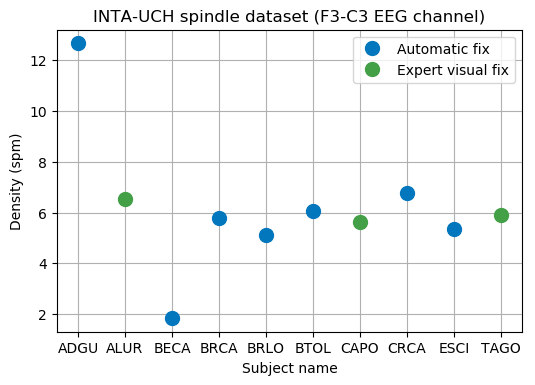

In [38]:
revised = ['ALUR', 'CAPO', 'TAGO']
manual_not_shown = True
auto_not_shown = True
fig, ax = plt.subplots(1, 1, figsize=(6, 4), dpi=100)
for subject_id in dataset.all_ids:
    subject_name = dataset.get_name(subject_id)
    if subject_name in revised:
        color = viz.PALETTE['green']
        label = "Expert visual fix" if manual_not_shown else None
        manual_not_shown = False
    else:
        color = viz.PALETTE['blue']
        label = "Automatic fix" if auto_not_shown else None
        auto_not_shown = False
    ax.plot(
        subject_id, densities[subject_id-1], linestyle="none", marker='o', color=color, markersize=10,
        label=label)
ax.set_xticks(dataset.all_ids)
ax.set_xticklabels(dataset.names)
ax.set_xlabel("Subject name")
ax.set_ylabel("Density (spm)")
ax.grid()
ax.legend()
ax.set_title("INTA-UCH spindle dataset (F3-C3 EEG channel)")
plt.show()

In [44]:
print("total n2 pages of 20s: %d (%1.2f h)" % (total_n2_pages, total_n2_pages * 20 / 3600))

total n2 pages of 20s: 5930 (32.94 h)


In [46]:
total_spindles

11964

In [47]:
stacked_durations = np.concatenate(all_durations)

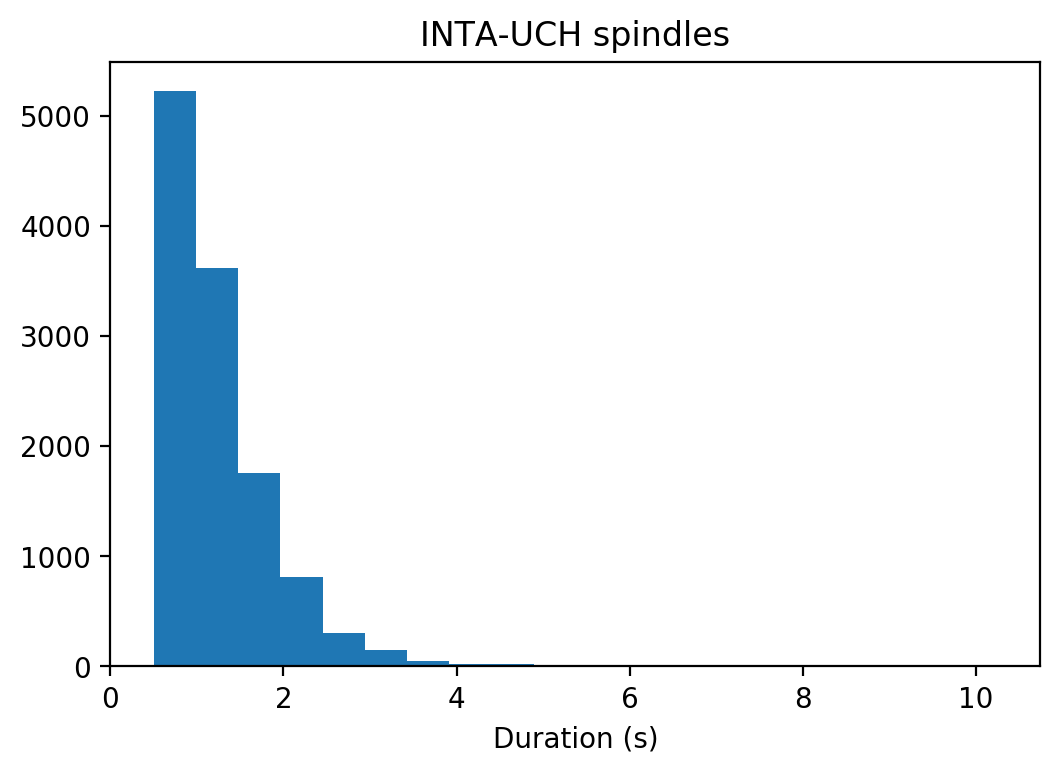

In [66]:
plt.figure(dpi=200)
plt.hist(stacked_durations, bins=20)
plt.xlim([0, None])
plt.title("INTA-UCH spindles")
plt.xlabel("Duration (s)")
plt.show()

In [55]:
stacked_durations.max()

10.26

In [64]:
np.sum(stacked_durations >= 4)

56

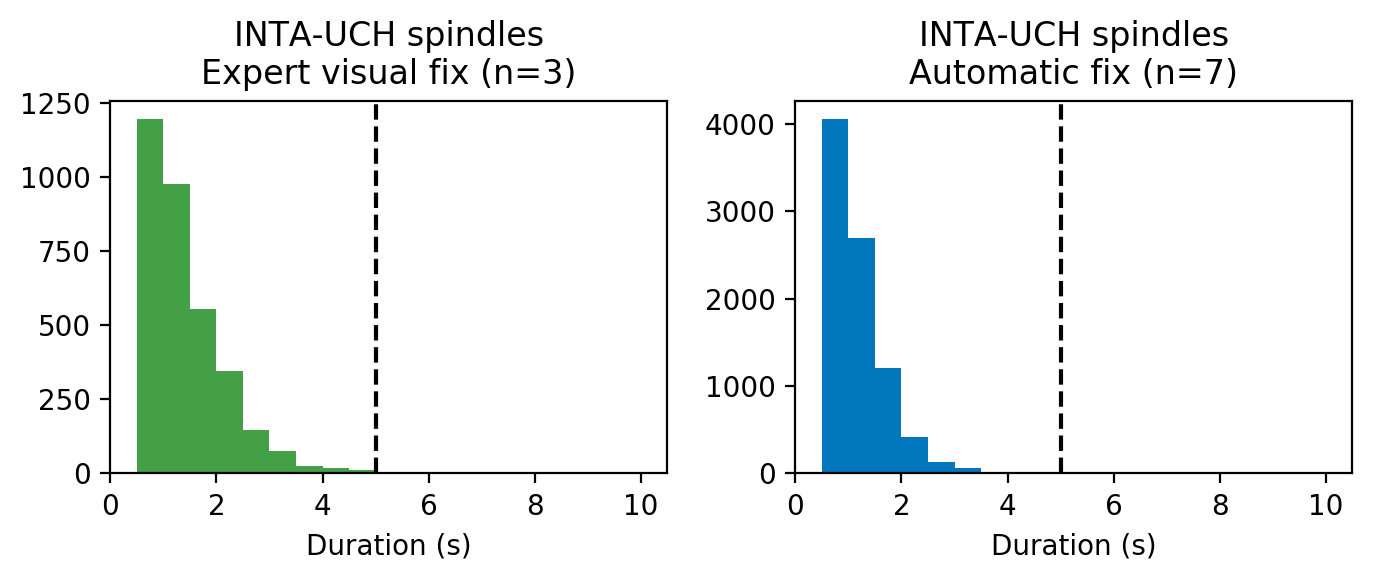

Revised outside max_duration: 14
Auto outside max_duration: 5


In [88]:
revised_durations = []
auto_durations = []
for i, durations in enumerate(all_durations):
    subject_name = dataset.get_name(i+1)
    if subject_name in revised:
        revised_durations.append(durations)
    else:
        auto_durations.append(durations)
revised_durations = np.concatenate(revised_durations)
auto_durations = np.concatenate(auto_durations)

max_duration = 5.0
fig, ax = plt.subplots(1, 2, dpi=200, figsize=(7, 3), sharex=True)
bins = np.arange(0, 10+0.001, 0.5)
ax[0].hist(revised_durations, bins=bins, color=viz.PALETTE['green'])
ax[1].hist(auto_durations, bins=bins, color=viz.PALETTE['blue'])
ax[0].set_xlim([0, None])
ax[1].set_xlim([0, None])
ax[0].set_title("INTA-UCH spindles\nExpert visual fix (n=3)")
ax[1].set_title("INTA-UCH spindles\nAutomatic fix (n=7)")
ax[0].set_xlabel("Duration (s)")
ax[1].set_xlabel("Duration (s)")
ax[0].axvline(max_duration, color="k", linestyle="--")
ax[1].axvline(max_duration, color="k", linestyle="--")
plt.tight_layout()
plt.show()

print("Revised outside max_duration:", np.sum(revised_durations > max_duration))
print("Auto outside max_duration:", np.sum(auto_durations > max_duration))

In [8]:
n_folds = 5
for fold_id in range(n_folds):
    print(dataset.cv_split(n_folds, fold_id, seed=2))

(array([ 3,  4,  7,  8,  9, 10]), array([1, 6]), array([2, 5]))
(array([ 2,  4,  5,  7,  9, 10]), array([3, 8]), array([1, 6]))
(array([ 1,  2,  5,  6,  9, 10]), array([4, 7]), array([3, 8]))
(array([1, 2, 3, 5, 6, 8]), array([ 9, 10]), array([4, 7]))
(array([1, 3, 4, 6, 7, 8]), array([2, 5]), array([ 9, 10]))
